# Imports and configs

In [2]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import joblib
import glob
import gc
import time

warnings.filterwarnings("ignore")

In [18]:
class CFG:
    train_path = "input/train.parquet"
    test_path = "input/test.parquet"
    sample_sub_path = "input/sample_submission.csv"

    target = "label"
    features_main = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
    features_x = ['X' + str(i) for i in range(1,780+1)]

    n_folds = 3
    seed = 42

    run_optuna = True
    n_optuna_trials = 100 

# Data loading

Discussion„ÅßÊãæ„Å£„Å¶„Åç„Åü„ÇÑ„Å§„ÄÇ„Éá„Éº„ÇøÈáè„ÇíÂúßÁ∏Æ„Åó„Å¶ÂàÜÊûêÂäπÁéá„Çí‰∏ä„Åí„Çã„Åì„Å®„Åå„Åß„Åç„Çã„ÄÇ
https://www.kaggle.com/competitions/drw-crypto-market-prediction/discussion/580485

In [4]:
def reduce_mem_usage(dataframe, dataset):    
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2

    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe


In [5]:
train = pd.read_parquet(CFG.train_path).reset_index(drop=True)
test = pd.read_parquet(CFG.test_path).reset_index(drop=True)

train = reduce_mem_usage(train, "train")
test = reduce_mem_usage(test, "test")

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test.drop(CFG.target, axis=1)

Reducing memory usage for: train
--- Memory usage before: 3153.58 MB
--- Memory usage after: 788.40 MB
--- Decreased memory usage by 75.0%

Reducing memory usage for: test
--- Memory usage before: 3227.13 MB
--- Memory usage after: 806.27 MB
--- Decreased memory usage by 75.0%



# Preprocessing

In [6]:
train.head()

bid_qty    ask_qty   buy_qty   sell_qty   volume        X1        X2  \
0  15.281250   8.421875  176.3750   44.96875  221.375  0.181885 -0.637695   
1  38.593750   2.335938  526.0000  322.00000  848.000  0.489502 -0.075623   
2   0.441895  60.250000  159.2500  136.37500  295.500  0.260010 -0.444580   
3   4.863281  21.015625  335.7500  124.93750  460.750  0.099976 -0.666504   
4  27.156250   3.451172   98.4375   44.40625  142.875  0.270996 -0.325928   

         X3        X4        X5  ...      X772      X773      X774      X775  \
0  0.006653  0.136841  0.116699  ...  0.333740 -0.009995 -0.695801 -0.444092   
1  0.431641  0.522461  0.475342  ...  0.333740 -0.010040 -0.696289 -0.452881   
2  0.100708  0.224731  0.203247  ...  0.333740 -0.010040 -0.696777 -0.461426   
3 -0.123840  0.019196  0.014458  ...  0.333252 -0.010277 -0.697266 -0.469727   
4  0.116333  0.234253  0.214111  ...  0.333252 -0.010284 -0.697754 -0.477539   

       X776      X777      X778      X779      X780     label  
0 -0.191284 -0.184204 -0.471924 -0.625488 -0.554199  0.562500  
1 -0.200073 -0.188965 -0.472900 -0.625977 -0.554199  0.533691  
2 -0.208740 -0.193604 -0.473877 -0.626465 -0.554688  0.546387  
3 -0.217407 -0.198120 -0.474609 -0.626465 -0.555176  0.357666  
4 -0.225830 -0.202759 -0.475586 -0.626953 -0.555664  0.362549  

[5 rows x 786 columns]

In [7]:

# ‚îÄ‚îÄ ÂâçÂá¶ÁêÜ ‚îÄ‚îÄ
# Êï∞ÂÄ§Âàó„ÅÆ„ÅøÊäΩÂá∫ÔºàX1ÔΩûX200ÔºâÈáç„Åô„Åé„Çã„ÅÆ„Åß„ÄÇ
X_num = X[CFG.features_x].select_dtypes(include=[np.number])

# ‚àû „Çí NaN „Å´ÁΩÆÊèõ
X_num = X_num.replace([np.inf, -np.inf], np.nan)

# Ê¨†Êêç„ÇíÂêÑÂàó„ÅÆ‰∏≠Â§ÆÂÄ§„ÅßÂüã„ÇÅ„Çã
X_clean = X_num.fillna(X_num.median())

# „Åæ„Å† NaN „ÇíÂê´„ÇÄÂàó„Çí‰∏∏„Åî„Å®Èô§Â§ñ
X_clean = X_clean.dropna(axis=1, how='any')

# float32 „Å´„ÉÄ„Ç¶„É≥„Ç≠„É£„Çπ„Éà
X_clean = X_clean.astype(np.float32)

# Ê®ôÊ∫ñÂåñ
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

null_counts = X_clean.isnull().sum()
print(f"Null counts per column:")
print(null_counts[null_counts > 0])

X_clean.head()

Null counts per column:
Series([], dtype: int64)


X1        X2        X3        X4        X5        X6        X7  \
0  0.181885 -0.637695  0.006653  0.136841  0.116699  0.050171  0.063416   
1  0.489502 -0.075623  0.431641  0.522461  0.475342  0.380615  0.383789   
2  0.260010 -0.444580  0.100708  0.224731  0.203247  0.133057  0.144287   
3  0.099976 -0.666504 -0.123840  0.019196  0.014458 -0.039398 -0.022705   
4  0.270996 -0.325928  0.116333  0.234253  0.214111  0.144409  0.155396   

         X8        X9       X10  ...      X771      X772      X773      X774  \
0  0.118408  1.499023 -0.058380  ... -0.868164  0.333740 -0.009995 -0.695801   
1  0.433350  1.364258 -0.362549  ...  0.194214  0.333740 -0.010040 -0.696289   
2  0.198120  1.283203 -0.517578  ...  0.270508  0.333740 -0.010040 -0.696777   
3  0.034119  1.026367 -1.058594  ...  0.425781  0.333252 -0.010277 -0.697266   
4  0.208984  1.075195 -0.851562  ...  0.445068  0.333252 -0.010284 -0.697754   

       X775      X776      X777      X778      X779      X780  
0 -0.444092 -0.191284 -0.184204 -0.471924 -0.625488 -0.554199  
1 -0.452881 -0.200073 -0.188965 -0.472900 -0.625977 -0.554199  
2 -0.461426 -0.208740 -0.193604 -0.473877 -0.626465 -0.554688  
3 -0.469727 -0.217407 -0.198120 -0.474609 -0.626465 -0.555176  
4 -0.477539 -0.225830 -0.202759 -0.475586 -0.626953 -0.555664  

[5 rows x 780 columns]

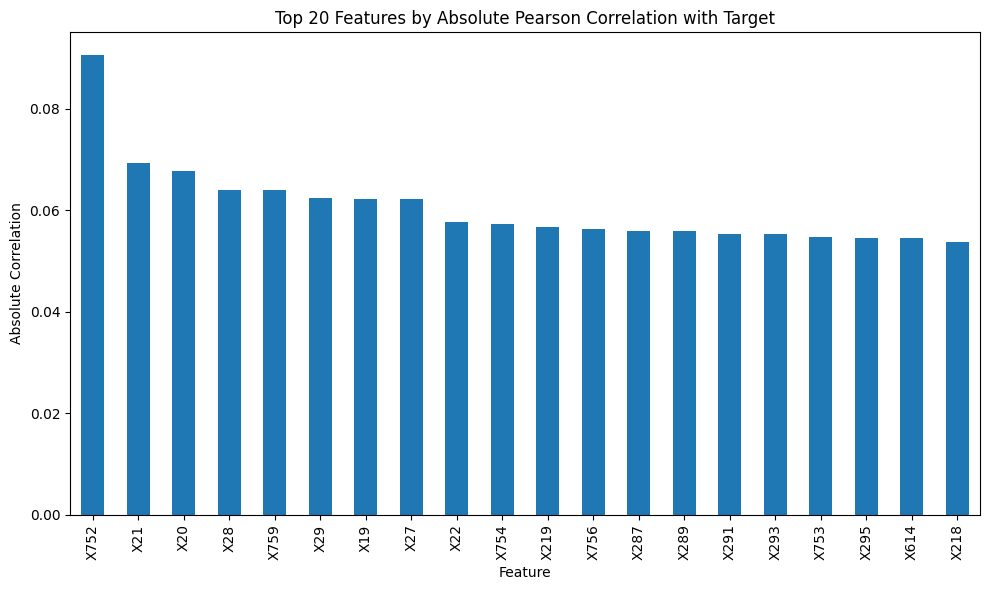

In [8]:
# Pearson correlation
corr = X_clean.corrwith(y)
corr_abs = corr.abs().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
corr_abs.iloc[:20].plot.bar()
plt.title('Top 20 Features by Absolute Pearson Correlation with Target')
plt.ylabel('Absolute Correlation')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [9]:
import lightgbm as lgb

# Â≠¶ÁøíÁî®„Éá„Éº„Çø„Çª„ÉÉ„Éà„Çí‰ΩúÊàê
dtrain = lgb.Dataset(X_clean, label=y)

# GPU„Çí‰Ωø„ÅÜ„Åü„ÇÅ„ÅÆ„Éë„É©„É°„Éº„Çø
params = {
    'objective': 'regression',   # ÂõûÂ∏∞ÂïèÈ°å
    'metric': 'rmse',            # Ë©ï‰æ°ÊåáÊ®ôÔºàRMSEÔºâ
    'device': 'gpu',             # ‚Üê „Åì„Åì„ÅßGPUÊåáÂÆö
    'gpu_platform_id': 0,        # OpenCL„Éó„É©„ÉÉ„Éà„Éï„Ç©„Éº„É†ID„ÄÇÈÄöÂ∏∏„ÅØ0
    'gpu_device_id': 0,          # GPU„Éá„Éê„Ç§„ÇπID„ÄÇÈÄöÂ∏∏„ÅØ0
    'learning_rate': 0.1,
    'num_leaves': 64,
    'max_depth': 7,
}

# „Åî„ÅèÂ∞ëÈáè„ÅÆ„Éñ„Éº„Çπ„Éà„É©„Ç¶„É≥„Éâ„ÅßÂãï‰ΩúÁ¢∫Ë™ç
gbm = lgb.train(
    params,
    dtrain,
    num_boost_round=100,
    callbacks=[lgb.log_evaluation(5)]
)


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 198893
[LightGBM] [Info] Number of data points in the train set: 525886, number of used features: 780
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 772 dense feature groups (387.18 MB) transferred to GPU in 0.106996 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.036126


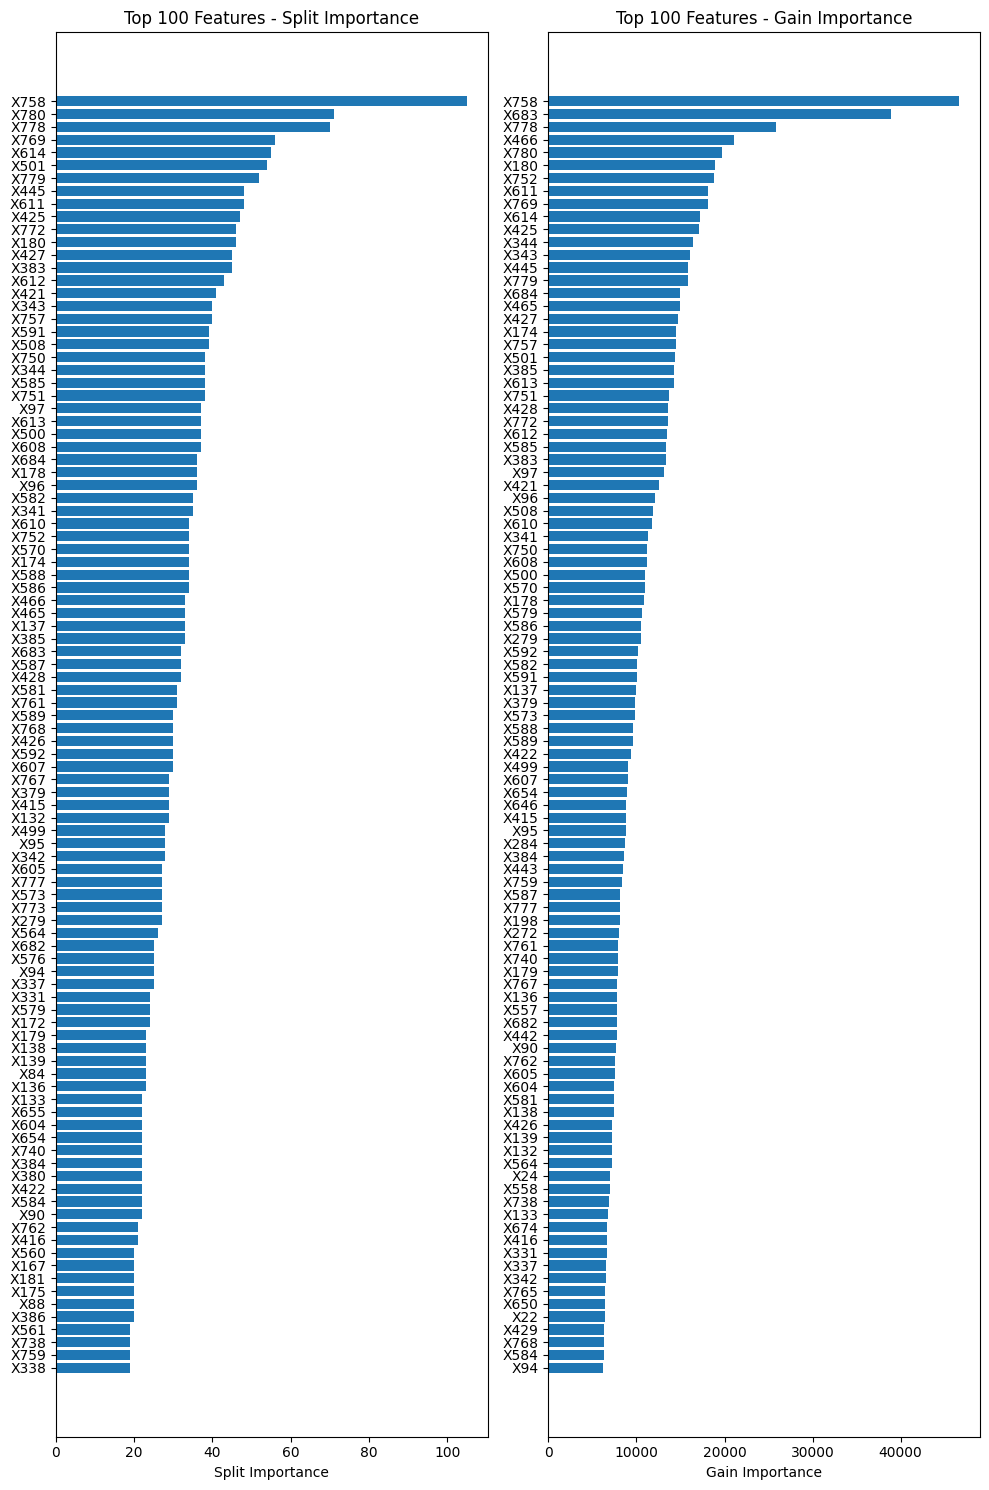

=== Top 10 Features by Gain Importance ===
    feature  gain_importance
757    X758     46670.992146
682    X683     38910.568783
777    X778     25893.654671
465    X466     21064.609474
779    X780     19666.493324
179    X180     18942.536453
751    X752     18796.673950
610    X611     18164.246086
768    X769     18097.019335
613    X614     17266.860352

=== Top 10 Features by Split Importance ===
    feature  split_importance
757    X758               105
779    X780                71
777    X778                70
768    X769                56
613    X614                55
500    X501                54
778    X779                52
444    X445                48
610    X611                48
424    X425                47

=== Importance Statistics ===
Total features: 780
Features with gain > 0: 609
Top feature (gain): X758 = 46670.9921


In [10]:
# LightGBM Â§âÊï∞ÈáçË¶ÅÂ∫¶„ÅÆÂèñÂæó„Å®ÂèØË¶ñÂåñ
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Split importanceÔºàÂàÜÂ≤êÂõûÊï∞„Éô„Éº„ÇπÔºâ
split_importance = gbm.feature_importance(importance_type='split')
split_importance_df = pd.DataFrame({
    'feature': X_clean.columns,
    'split_importance': split_importance
}).sort_values('split_importance', ascending=False)

# 2. Gain importanceÔºà„Ç≤„Ç§„É≥„Éô„Éº„Çπ - „Çà„ÇäÈáçË¶ÅÔºâ
gain_importance = gbm.feature_importance(importance_type='gain')
gain_importance_df = pd.DataFrame({
    'feature': X_clean.columns,
    'gain_importance': gain_importance
}).sort_values('gain_importance', ascending=False)

# 3. ÂèØË¶ñÂåñ
fig, axes = plt.subplots(1, 2, figsize=(10, 15))

# Split importance „ÅÆ„Éó„É≠„ÉÉ„Éà
axes[0].barh(split_importance_df.head(100)['feature'], 
             split_importance_df.head(100)['split_importance'])
axes[0].set_title('Top 100 Features - Split Importance')
axes[0].set_xlabel('Split Importance')
axes[0].invert_yaxis()

# Gain importance „ÅÆ„Éó„É≠„ÉÉ„Éà
axes[1].barh(gain_importance_df.head(100)['feature'], 
             gain_importance_df.head(100)['gain_importance'])
axes[1].set_title('Top 100 Features - Gain Importance')
axes[1].set_xlabel('Gain Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# 4. ‰∏ä‰ΩçÈáçË¶ÅÂ∫¶„ÅÆÊï∞ÂÄ§Ë°®Á§∫
print("=== Top 10 Features by Gain Importance ===")
print(gain_importance_df.head(10))

print("\n=== Top 10 Features by Split Importance ===")
print(split_importance_df.head(10))

# 5. ÈáçË¶ÅÂ∫¶„ÅÆË¶ÅÁ¥ÑÁµ±Ë®à
print(f"\n=== Importance Statistics ===")
print(f"Total features: {len(X_clean.columns)}")
print(f"Features with gain > 0: {(gain_importance > 0).sum()}")
print(f"Top feature (gain): {gain_importance_df.iloc[0]['feature']} = {gain_importance_df.iloc[0]['gain_importance']:.4f}")

In [13]:
top_50_features = gain_importance_df.head(50)['feature']

features = [
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume",
    *top_50_features,
]

X = X[features]
X_test = X_test[features]

# Training base model

In [19]:
# ÂÖ±ÈÄöË®≠ÂÆö
kf = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)

In [20]:
def pearson_score(y_true, y_pred):
    """PearsonÁõ∏Èñ¢„Çπ„Ç≥„Ç¢"""
    return pearsonr(y_true, y_pred)[0]

In [21]:

def run_cross_validation(model, X, y, model_name="Model", cv_folds=None):
    """
    foldÂà•Ë©≥Á¥∞ÁµêÊûúË°®Á§∫ÂØæÂøú„ÇØ„É≠„Çπ„Éê„É™„Éá„Éº„Ç∑„Éß„É≥Èñ¢Êï∞
    
    Parameters:
    -----------
    model : sklearn compatible model
        Â≠¶Áøí„Åï„Åõ„Çã„É¢„Éá„É´
    X : pandas.DataFrame
        ÁâπÂæ¥Èáè„Éá„Éº„Çø
    y : pandas.Series
        ÁõÆÁöÑÂ§âÊï∞
    model_name : str
        „É¢„Éá„É´Âêç
    cv_folds : KFold object
        „ÇØ„É≠„Çπ„Éê„É™„Éá„Éº„Ç∑„Éß„É≥Ë®≠ÂÆö
    
    Returns:
    --------
    dict : CVÁµêÊûú„ÅÆËæûÊõ∏
    """
    
    if cv_folds is None:
        cv_folds = KFold(n_splits=CFG.n_folds, shuffle=False, random_state=None)
    
    print(f"=== {model_name} Cross Validation ÈñãÂßã ===")
    
    # ÁµêÊûú‰øùÂ≠òÁî®
    fold_results = []
    rmse_scores = []
    r2_scores = []
    pearson_scores = []
    times = []
    
    # ÂêÑfoldÂÆüË°å
    for fold, (train_idx, val_idx) in enumerate(cv_folds.split(X, y)):
        start_time = time.time()
        
        # „Éá„Éº„ÇøÂàÜÂâ≤
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # „É¢„Éá„É´Â≠¶Áøí
        model.fit(X_train, y_train)
        
        # ‰∫àÊ∏¨
        y_pred = model.predict(X_val)
        
        # Ë©ï‰æ°ÊåáÊ®ôË®àÁÆó
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        pearson = pearsonr(y_val, y_pred)[0]
        
        # ÂÆüË°åÊôÇÈñì
        fold_time = time.time() - start_time
        
        # ÁµêÊûú‰øùÂ≠ò
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        pearson_scores.append(pearson)
        times.append(fold_time)
        
        fold_results.append({
            'fold': fold,
            'rmse': rmse,
            'r2': r2,
            'pearson': pearson,
            'time': fold_time
        })
        
        # foldÂà•ÁµêÊûúË°®Á§∫
        print(f"--- Fold {fold} - pearsonr: {pearson:.6f} - Time: {fold_time:.2f} s")
    
    # ÂÖ®‰ΩìÁµ±Ë®à
    results = {
        'fold_results': fold_results,
        'rmse': {
            'mean': np.mean(rmse_scores),
            'std': np.std(rmse_scores),
            'scores': rmse_scores
        },
        'r2': {
            'mean': np.mean(r2_scores),
            'std': np.std(r2_scores),
            'scores': r2_scores
        },
        'pearson': {
            'mean': np.mean(pearson_scores),
            'std': np.std(pearson_scores),
            'scores': pearson_scores
        },
        'time': {
            'mean': np.mean(times),
            'total': np.sum(times)
        }
    }
    
    # ÂÖ®‰ΩìÁµêÊûúË°®Á§∫
    print(f"\n{model_name} Overall Results:")
    print(f"  RMSE: {results['rmse']['mean']:.6f} ¬± {results['rmse']['std']:.6f}")
    print(f"  R¬≤: {results['r2']['mean']:.6f} ¬± {results['r2']['std']:.6f}")
    print(f"  Pearson: {results['pearson']['mean']:.6f} ¬± {results['pearson']['std']:.6f}")
    print(f"  Total Time: {results['time']['total']:.2f} s")
    print()
    
    return results

## LightGBM (gbdt)

In [22]:
print("üìä LightGBMÂ≠¶ÁøíÈñãÂßã")
lgbm_model = LGBMRegressor(
    objective='regression',
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    learning_rate=0.1,
    num_leaves=64,
    max_depth=7,
    n_estimators=1000,
    verbose=-1
)

lgbm_results = run_cross_validation(
    model=lgbm_model,
    X=X,
    y=y,
    model_name="LightGBM",
    cv_folds=kf
)

üìä LightGBMÂ≠¶ÁøíÈñãÂßã
=== LightGBM Cross Validation ÈñãÂßã ===
--- Fold 0 - pearsonr: 0.969000 - Time: 14.15 s
--- Fold 1 - pearsonr: 0.968517 - Time: 14.14 s
--- Fold 2 - pearsonr: 0.969843 - Time: 14.06 s

LightGBM Overall Results:
  RMSE: 0.255235 ¬± 0.002086
  R¬≤: 0.936124 ¬± 0.000986
  Pearson: 0.969120 ¬± 0.000548
  Total Time: 42.35 s



## XGBoost

In [23]:
print("üìä XGBoostÂ≠¶ÁøíÈñãÂßã")
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    learning_rate=0.1,
    max_depth=7,
    n_estimators=1000,
    verbosity=0
)

xgb_results = run_cross_validation(
    model=xgb_model,
    X=X,
    y=y,
    model_name="XGBoost",
    cv_folds=kf
)

üìä XGBoostÂ≠¶ÁøíÈñãÂßã
=== XGBoost Cross Validation ÈñãÂßã ===
--- Fold 0 - pearsonr: 0.975307 - Time: 10.61 s
--- Fold 1 - pearsonr: 0.974950 - Time: 10.37 s
--- Fold 2 - pearsonr: 0.975992 - Time: 10.47 s

XGBoost Overall Results:
  RMSE: 0.227468 ¬± 0.001915
  R¬≤: 0.949266 ¬± 0.000804
  Pearson: 0.975417 ¬± 0.000432
  Total Time: 31.44 s



## NN

In [24]:
# CPUÁî®„Å´ÊúÄÈÅ©Âåñ„Åï„Çå„ÅüMLP
print("üèÉ‚Äç‚ôÇÔ∏è ÊúÄÈÅ©ÂåñMLP (CPU) Â≠¶ÁøíÈñãÂßã")

optimized_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(128, 64),  # Â±§„ÇíÊ∏õ„Çâ„Åó„Å¶È´òÈÄüÂåñ
        activation='relu',
        solver='adam',
        alpha=0.01,  # Ê≠£ÂâáÂåñ„ÇíÂº∑„ÇÅ„Å¶ÈÅéÂ≠¶ÁøíÊäëÂà∂
        batch_size=200,  # „Éê„ÉÉ„ÉÅ„Çµ„Ç§„Ç∫„ÇíÂ§ß„Åç„Åè„Åó„Å¶È´òÈÄüÂåñ
        learning_rate='adaptive',
        learning_rate_init=0.01,
        max_iter=300,  # ÂèçÂæ©Êï∞„ÇíÊ∏õ„Çâ„Åó„Å¶È´òÈÄüÂåñ
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20  # Êó©ÊúüÂÅúÊ≠¢„ÇíÊó©„ÇÅ„Å¶È´òÈÄüÂåñ
    ))
])

optimized_mlp_results = run_cross_validation(
    model=optimized_mlp,
    X=X,
    y=y,
    model_name="Optimized MLP (CPU)",
    cv_folds=kf
)

üèÉ‚Äç‚ôÇÔ∏è ÊúÄÈÅ©ÂåñMLP (CPU) Â≠¶ÁøíÈñãÂßã
=== Optimized MLP (CPU) Cross Validation ÈñãÂßã ===
--- Fold 0 - pearsonr: 0.808694 - Time: 182.67 s
--- Fold 1 - pearsonr: 0.824957 - Time: 277.83 s
--- Fold 2 - pearsonr: 0.817329 - Time: 264.28 s

Optimized MLP (CPU) Overall Results:
  RMSE: 0.582909 ¬± 0.010265
  R¬≤: 0.666762 ¬± 0.011384
  Pearson: 0.816993 ¬± 0.006644
  Total Time: 724.79 s



# Ensemble

In [26]:

def create_ensemble_predictions(trained_models, model_names, X, y, X_test, cv_folds):
    """
    Â≠¶ÁøíÊ∏à„Åø„É¢„Éá„É´„Çí‰Ωø„Å£„Å¶„Ç¢„É≥„Çµ„É≥„Éñ„É´Áî®„ÅÆ‰∫àÊ∏¨„Çí‰ΩúÊàê
    
    Parameters:
    -----------
    trained_models : dict
        Â≠¶ÁøíÊ∏à„Åø„É¢„Éá„É´„ÅÆËæûÊõ∏ {'model_name': model}
    model_names : list
        ‰ΩøÁî®„Åô„Çã„É¢„Éá„É´Âêç„ÅÆ„É™„Çπ„Éà
    X, y : DataFrame, Series
        Â≠¶Áøí„Éá„Éº„Çø
    X_test : DataFrame
        „ÉÜ„Çπ„Éà„Éá„Éº„Çø
    cv_folds : KFold
        „ÇØ„É≠„Çπ„Éê„É™„Éá„Éº„Ç∑„Éß„É≥Ë®≠ÂÆö
        
    Returns:
    --------
    oof_predictions : DataFrame
        Out-of-Fold‰∫àÊ∏¨„Éá„Éº„Çø„Éï„É¨„Éº„É†
    test_predictions : DataFrame
        „ÉÜ„Çπ„Éà„Éá„Éº„Çø‰∫àÊ∏¨„Éá„Éº„Çø„Éï„É¨„Éº„É†
    """
    
    print("üîÑ Â≠¶ÁøíÊ∏à„Åø„É¢„Éá„É´„Åß„Ç¢„É≥„Çµ„É≥„Éñ„É´‰∫àÊ∏¨‰ΩúÊàê‰∏≠...")
    
    # ÁµêÊûú‰øùÂ≠òÁî®ËæûÊõ∏
    oof_preds = {}
    test_preds = {}
    
    for model_name in model_names:
        print(f"  üìä {model_name} „ÅÆ„Ç¢„É≥„Çµ„É≥„Éñ„É´‰∫àÊ∏¨‰ΩúÊàê‰∏≠...")
        
        # OOF‰∫àÊ∏¨Áî®ÈÖçÂàóÂàùÊúüÂåñ
        oof_pred = np.zeros(len(X))
        test_pred_folds = []
        
        # ÂêÑfold„Åß‰∫àÊ∏¨
        for fold, (train_idx, val_idx) in enumerate(cv_folds.split(X, y)):
            # „Éá„Éº„ÇøÂàÜÂâ≤
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Â≠¶ÁøíÊ∏à„Åø„É¢„Éá„É´„Çí„ÇØ„É≠„Éº„É≥„Åó„Å¶ÂÜçÂ≠¶Áøí
            # (Â≠¶ÁøíÊ∏à„Åø„Éë„É©„É°„Éº„Çø„Çí‰ΩøÁî®„Åô„Çã„Åü„ÇÅ„ÄÅÂêå„ÅòË®≠ÂÆö„ÅßÂ≠¶Áøí)
            fold_model = clone(trained_models[model_name])
            fold_model.fit(X_train, y_train)
            
            # OOF‰∫àÊ∏¨
            oof_pred[val_idx] = fold_model.predict(X_val)
            
            # „ÉÜ„Çπ„Éà„Éá„Éº„Çø‰∫àÊ∏¨
            test_pred_folds.append(fold_model.predict(X_test))
            
        # „ÉÜ„Çπ„Éà„Éá„Éº„Çø‰∫àÊ∏¨„ÅÆÂπ≥Âùá
        test_pred = np.mean(test_pred_folds, axis=0)
        
        # ÁµêÊûú‰øùÂ≠ò
        oof_preds[model_name] = oof_pred
        test_preds[model_name] = test_pred
        
        # OOFÊÄßËÉΩÁ¢∫Ë™ç
        oof_pearson = pearsonr(y, oof_pred)[0]
        print(f"    ‚úÖ {model_name} OOF Pearson: {oof_pearson:.6f}")
    
    # DataFrame„Å´Â§âÊèõ
    oof_df = pd.DataFrame(oof_preds)
    test_df = pd.DataFrame(test_preds)
    
    return oof_df, test_df

In [27]:

def optimize_ridge_alpha(oof_predictions, y, alphas=None):
    """
    RidgeÂõûÂ∏∞„ÅÆalpha„Éë„É©„É°„Éº„Çø„ÇíÊúÄÈÅ©Âåñ
    
    Parameters:
    -----------
    oof_predictions : DataFrame
        OOF‰∫àÊ∏¨„Éá„Éº„Çø„Éï„É¨„Éº„É†
    y : Series
        ÁõÆÁöÑÂ§âÊï∞
    alphas : list
        Ë©¶Ë°å„Åô„Çãalpha„ÅÆÂÄ§„É™„Çπ„Éà
        
    Returns:
    --------
    best_alpha : float
        ÊúÄÈÅ©„Å™alphaÂÄ§
    """
    
    if alphas is None:
        alphas = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
    
    print("üîç Ridge alpha „Éë„É©„É°„Éº„ÇøÊúÄÈÅ©Âåñ‰∏≠...")
    
    best_alpha = None
    best_score = -np.inf
    
    for alpha in alphas:
        ridge = Ridge(alpha=alpha, random_state=CFG.seed)
        
        # „ÇØ„É≠„Çπ„Éê„É™„Éá„Éº„Ç∑„Éß„É≥„Åß„Çπ„Ç≥„Ç¢Ë®àÁÆó
        scores = cross_val_score(
            ridge, oof_predictions, y, 
            cv=5, 
            scoring='neg_mean_squared_error'
        )
        mean_score = scores.mean()
        
        print(f"  alpha={alpha:>6}: CV Score = {-mean_score:.6f}")
        
        if mean_score > best_score:
            best_score = mean_score
            best_alpha = alpha
    
    print(f"‚úÖ ÊúÄÈÅ©alpha: {best_alpha}")
    return best_alpha

In [28]:
def ridge_ensemble_final(oof_predictions, test_predictions, y, alpha=None):
    """
    Ridge„Åß„Ç¢„É≥„Çµ„É≥„Éñ„É´„É¢„Éá„É´„ÇíÂ≠¶Áøí„Éª‰∫àÊ∏¨
    
    Parameters:
    -----------
    oof_predictions : DataFrame
        OOF‰∫àÊ∏¨„Éá„Éº„Çø„Éï„É¨„Éº„É†
    test_predictions : DataFrame  
        „ÉÜ„Çπ„Éà„Éá„Éº„Çø‰∫àÊ∏¨„Éá„Éº„Çø„Éï„É¨„Éº„É†
    y : Series
        ÁõÆÁöÑÂ§âÊï∞
    alpha : float
        RidgeÊ≠£ÂâáÂåñ„Éë„É©„É°„Éº„ÇøÔºàNone„ÅÆÂ†¥Âêà„ÅØÊúÄÈÅ©ÂåñÔºâ
        
    Returns:
    --------
    ridge_model : Ridge
        Â≠¶ÁøíÊ∏à„ÅøRidge„É¢„Éá„É´
    final_predictions : ndarray
        ÊúÄÁµÇ„Ç¢„É≥„Çµ„É≥„Éñ„É´‰∫àÊ∏¨
    model_weights : ndarray
        ÂêÑ„É¢„Éá„É´„ÅÆÈáç„Åø
    """
    
    print("Ridge Ensemble ÊúÄÁµÇÂ≠¶ÁøíÈñãÂßã")
    
    # alphaÊúÄÈÅ©ÂåñÔºàÊåáÂÆö„Åï„Çå„Å¶„ÅÑ„Å™„ÅÑÂ†¥ÂêàÔºâ
    if alpha is None:
        alpha = optimize_ridge_alpha(oof_predictions, y)
    
    # RidgeÂ≠¶Áøí
    ridge_model = Ridge(alpha=alpha, random_state=CFG.seed)
    ridge_model.fit(oof_predictions, y)
    
    # ÊúÄÁµÇ‰∫àÊ∏¨
    final_predictions = ridge_model.predict(test_predictions)
    
    # „É¢„Éá„É´Èáç„ÅøÂèñÂæó
    model_weights = ridge_model.coef_
    
    print(f"\nüìà Ridge Ensemble Results (alpha={alpha}):")
    print(f"  ÂàáÁâá: {ridge_model.intercept_:.6f}")
    print(f"  „É¢„Éá„É´Èáç„Åø:")
    for name, weight in zip(oof_predictions.columns, model_weights):
        print(f"    {name}: {weight:.6f}")
    
    # OOF„Åß„ÅÆÊÄßËÉΩÁ¢∫Ë™ç
    oof_ensemble_pred = ridge_model.predict(oof_predictions)
    oof_pearson = pearsonr(y, oof_ensemble_pred)[0]
    oof_rmse = np.sqrt(mean_squared_error(y, oof_ensemble_pred))
    
    print(f"\n‚úÖ Ridge Ensemble OOF Performance:")
    print(f"  Pearson: {oof_pearson:.6f}")
    print(f"  RMSE: {oof_rmse:.6f}")
    
    return ridge_model, final_predictions, model_weights

In [29]:
def plot_weights(weights, model_names, title="Model Weights", figsize=(10, 6)):
    """
    „Ç¢„É≥„Çµ„É≥„Éñ„É´„É¢„Éá„É´„ÅÆÈáç„Åø„ÇíÂèØË¶ñÂåñ„Åô„ÇãÈñ¢Êï∞
    
    Parameters:
    -----------
    weights : array-like
        „É¢„Éá„É´„ÅÆÈáç„ÅøÔºà‰øÇÊï∞Ôºâ
    model_names : list
        „É¢„Éá„É´Âêç„ÅÆ„É™„Çπ„Éà
    title : str
        „Ç∞„É©„Éï„ÅÆ„Çø„Ç§„Éà„É´
    figsize : tuple
        Âõ≥„ÅÆ„Çµ„Ç§„Ç∫
    """
    
    # ÂÖ•Âäõ„Éá„Éº„Çø„ÅÆÊ§úË®º
    if len(weights) != len(model_names):
        raise ValueError(f"Èáç„Åø„ÅÆÊï∞({len(weights)})„Å®„É¢„Éá„É´Âêç„ÅÆÊï∞({len(model_names)})„Åå‰∏ÄËá¥„Åó„Åæ„Åõ„Çì")
    
    # weights„Åå2Ê¨°ÂÖÉÈÖçÂàó„ÅÆÂ†¥Âêà„ÅØ1Ê¨°ÂÖÉ„Å´Â§âÊèõ
    if isinstance(weights, np.ndarray) and weights.ndim == 2:
        weights = weights.flatten()
    
    # ÈôçÈ†Ü„Åß„ÇΩ„Éº„Éà
    sorted_indices = np.argsort(weights)[::-1]
    sorted_coeffs = np.array(weights)[sorted_indices]
    sorted_model_names = np.array(model_names)[sorted_indices]
    
    # „Ç∞„É©„Éï„Çµ„Ç§„Ç∫„ÇíÂãïÁöÑ„Å´Ë™øÊï¥
    height = max(len(model_names) * 0.5, 4)  # ÊúÄÂ∞è4, „É¢„Éá„É´Êï∞„Å´Âøú„Åò„Å¶Ë™øÊï¥
    
    plt.figure(figsize=(figsize[0], height))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")
    
    # Êï∞ÂÄ§„É©„Éô„É´„ÅÆËøΩÂä†
    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value + 0.01, i, f"{value:.3f}", va="center", ha="left", color="black", fontweight='bold')
        else:
            ax.text(value - 0.01, i, f"{value:.3f}", va="center", ha="right", color="black", fontweight='bold')
    
    # xËª∏„ÅÆÁØÑÂõ≤„ÇíË™øÊï¥Ôºà„É©„Éô„É´„ÅåË¶ã„Åà„Çã„Çà„ÅÜ„Å´Ôºâ
    xlim = ax.get_xlim()
    x_range = xlim[1] - xlim[0]
    ax.set_xlim(xlim[0] - 0.15 * x_range, xlim[1] + 0.15 * x_range)
    
    # „Ç∞„É©„Éï„ÅÆË£ÖÈ£æ
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Weight", fontsize=12)
    plt.ylabel("Model", fontsize=12)
    
    # 0„ÅÆÁ∑ö„ÇíËøΩÂä†ÔºàË≤†„ÅÆÈáç„Åø„Åå„ÅÇ„ÇãÂ†¥ÂêàÔºâ
    if np.any(sorted_coeffs < 0):
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    
    plt.tight_layout()
    plt.show()
    
    # Èáç„ÅøÊÉÖÂ†±„Çí„ÉÜ„Ç≠„Çπ„Éà„Åß„ÇÇË°®Á§∫
    print(f"\nüìä {title}")
    print("="*50)
    for name, weight in zip(sorted_model_names, sorted_coeffs):
        print(f"{name:15}: {weight:8.6f}")
    print("="*50)
    total_abs_weight = np.sum(np.abs(sorted_coeffs))
    print(f"{'Total |Weight|':15}: {total_abs_weight:8.6f}")

In [30]:
# Â≠¶ÁøíÊ∏à„Åø„É¢„Éá„É´„ÇíËæûÊõ∏„Å´„Åæ„Å®„ÇÅ„Çã
trained_models = {
    'LightGBM': lgbm_model,
    'XGBoost': xgb_model, 
    'MLP': optimized_mlp
}

model_names = ['LightGBM', 'XGBoost', 'MLP']

print("üöÄ Ridge Ensemble Pipeline ÈñãÂßã")
print(f"üìä ‰ΩøÁî®„É¢„Éá„É´: {model_names}")

# 1. „Ç¢„É≥„Çµ„É≥„Éñ„É´Áî®‰∫àÊ∏¨‰ΩúÊàê
oof_predictions, test_predictions = create_ensemble_predictions(
    trained_models=trained_models,
    model_names=model_names,
    X=X,
    y=y,
    X_test=X_test,
    cv_folds=kf
)

print(f"\nüìã „Ç¢„É≥„Çµ„É≥„Éñ„É´‰∫àÊ∏¨„Éá„Éº„ÇøÂΩ¢Áä∂:")
print(f"  OOF‰∫àÊ∏¨: {oof_predictions.shape}")
print(f"  „ÉÜ„Çπ„Éà‰∫àÊ∏¨: {test_predictions.shape}")

üöÄ Ridge Ensemble Pipeline ÈñãÂßã
üìä ‰ΩøÁî®„É¢„Éá„É´: ['LightGBM', 'XGBoost', 'MLP']
üîÑ Â≠¶ÁøíÊ∏à„Åø„É¢„Éá„É´„Åß„Ç¢„É≥„Çµ„É≥„Éñ„É´‰∫àÊ∏¨‰ΩúÊàê‰∏≠...
  üìä LightGBM „ÅÆ„Ç¢„É≥„Çµ„É≥„Éñ„É´‰∫àÊ∏¨‰ΩúÊàê‰∏≠...
    ‚úÖ LightGBM OOF Pearson: 0.969131
  üìä XGBoost „ÅÆ„Ç¢„É≥„Çµ„É≥„Éñ„É´‰∫àÊ∏¨‰ΩúÊàê‰∏≠...
    ‚úÖ XGBoost OOF Pearson: 0.975413
  üìä MLP „ÅÆ„Ç¢„É≥„Çµ„É≥„Éñ„É´‰∫àÊ∏¨‰ΩúÊàê‰∏≠...
    ‚úÖ MLP OOF Pearson: 0.816575

üìã „Ç¢„É≥„Çµ„É≥„Éñ„É´‰∫àÊ∏¨„Éá„Éº„ÇøÂΩ¢Áä∂:
  OOF‰∫àÊ∏¨: (525886, 3)
  „ÉÜ„Çπ„Éà‰∫àÊ∏¨: (538150, 3)


In [31]:
# 2. Ridge EnsembleÂ≠¶Áøí„Éª‰∫àÊ∏¨
ridge_model, ensemble_predictions, model_weights = ridge_ensemble_final(
    oof_predictions=oof_predictions,
    test_predictions=test_predictions,
    y=y,
    alpha=None  # Ëá™ÂãïÊúÄÈÅ©Âåñ
)

Ridge Ensemble ÊúÄÁµÇÂ≠¶ÁøíÈñãÂßã
üîç Ridge alpha „Éë„É©„É°„Éº„ÇøÊúÄÈÅ©Âåñ‰∏≠...
  alpha=  0.01: CV Score = 0.048683
  alpha=   0.1: CV Score = 0.048683
  alpha=   0.5: CV Score = 0.048683
  alpha=   1.0: CV Score = 0.048683
  alpha=   2.0: CV Score = 0.048683
  alpha=   5.0: CV Score = 0.048683
  alpha=  10.0: CV Score = 0.048683
  alpha=  20.0: CV Score = 0.048683
‚úÖ ÊúÄÈÅ©alpha: 20.0

üìà Ridge Ensemble Results (alpha=20.0):
  ÂàáÁâá: -0.001487
  „É¢„Éá„É´Èáç„Åø:
    LightGBM: 0.201689
    XGBoost: 0.887783
    MLP: -0.045703

‚úÖ Ridge Ensemble OOF Performance:
  Pearson: 0.975861
  RMSE: 0.220559


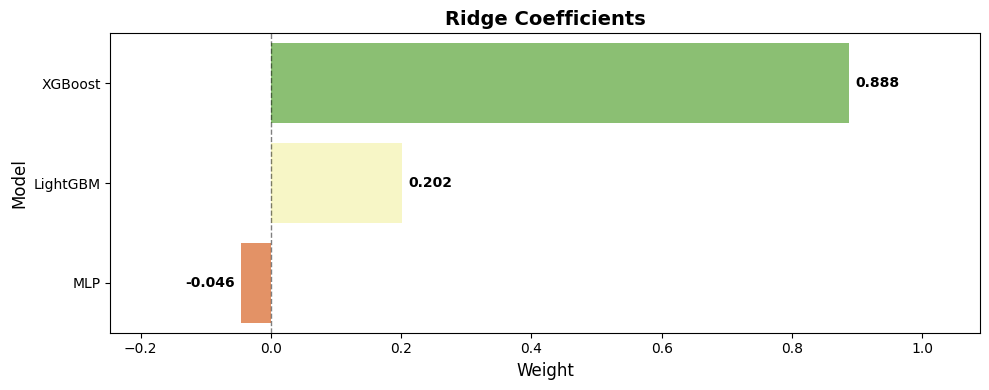


üìä Ridge Coefficients
XGBoost        : 0.887783
LightGBM       : 0.201689
MLP            : -0.045703
Total |Weight| : 1.135174


In [32]:
plot_weights(
    weights=model_weights,  # 1Ê¨°ÂÖÉÈÖçÂàó
    model_names=list(oof_predictions.columns),  # DataFrame„ÅÆ„Ç´„É©„É†Âêç„Åã„ÇâÂèñÂæó
    title="Ridge Coefficients"
)

# Submission

In [33]:
# „Çπ„Ç≥„Ç¢Ë®àÁÆó
ridge_oof_score = pearson_score(y, ridge_model.predict(oof_predictions))

# ÊèêÂá∫„Éï„Ç°„Ç§„É´
sub = pd.read_csv(CFG.sample_sub_path)
sub["prediction"] = ensemble_predictions
sub.to_csv(f"output/sub_ridge_{ridge_oof_score:.6f}.csv", index=False)


In [34]:
sub.head()

ID  prediction
0   1    0.722826
1   2    1.520665
2   3   -0.461899
3   4    0.397858
4   5    1.574213